# Project : Airbnb New User Booking
---

### Abstract :  

- purpose of prediction

- Model

- Score


### Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)

- evaluation question : 


### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
        
        - train / test categorical data :
        
        - sessions :
        
        - dropped data : age bkts, countries

### Conclusions :

##### A. Summary of Key Findings:

##### B. Final Analysis :
- * How does the author understand the data
- * How does the author believe the data will impact the program
- * Strengths and weaknesses of the program as revealed by evaluation findings 

##### C. Issues for Further Consideration (any outstanding issues raised by the evaluation) 

### 1. Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)


$$
DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}
$$

$$
nDCG_k=\frac{DCG_k}{IDCG_k}
$$


#### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
                
                - date_first_booking : dropped
                
                - age : filled by clustering age buckets
                
                - first_affiliate_tracked : filled by mode data
        
        - train / test categorical data : 
        
                - one-hot encoding
        
        - sessions :
        
                - action
                
                - action type
                
                - secs elapsed time
        
        - other features :
        
                - etc
                
                - etc
        
        - dropped data : age bkts, countries


#### Load data

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("../data/train_users_2.csv")
df_test = pd.read_csv("../data/test_users.csv")
df_all = pd.concat([df_train, df_test])
df_countries = pd.read_csv('../data/countries.csv')
df_sessions = pd.read_csv('../data/sessions.csv')
df_age_bkts = pd.read_csv('../data/age_gender_bkts.csv')

#### Missing value

In [12]:
df_all.drop("country_destination", axis = 1, inplace = True)

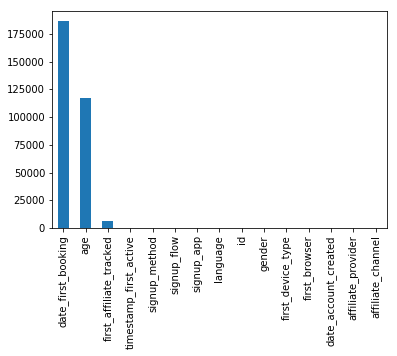

In [13]:
df_all.isnull().sum().sort_values(ascending = False).plot(kind="bar")

In [14]:
print('Missing data ratio')
print('date_frist_booking :',round(df_all.date_first_booking.isnull().sum() / len(df_all) * 100, 2))
print('age :',round(df_all.age.isnull().sum() / len(df_all) * 100, 2))
print('first_affiliate_tracked:',round(df_all.first_affiliate_tracked.isnull().sum() / len(df_all) * 100, 2))

Missing data ratio
date_frist_booking : 67.73
age : 42.41
first_affiliate_tracked: 2.21


#### (3) Explore Target

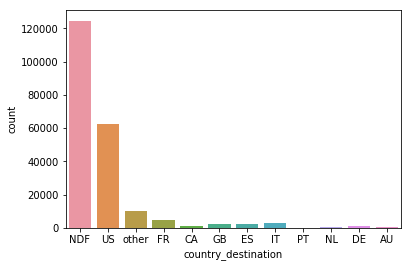

In [15]:
sns.countplot(df_train["country_destination"])

In [22]:
round(df_train["country_destination"].value_counts() / len(df_train) * 100, 2)

NDF      58.35
US       29.22
other     4.73
FR        2.35
IT        1.33
GB        1.09
ES        1.05
CA        0.67
DE        0.50
NL        0.36
AU        0.25
PT        0.10
Name: country_destination, dtype: float64

### 3. Feature Engineering

#### (1) Impute featrues

##### 1-1. Gender

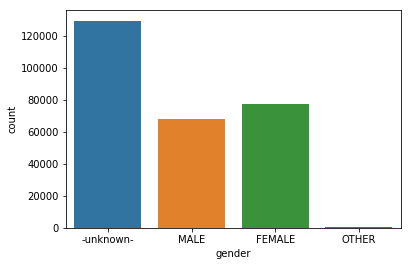

In [36]:
sns.countplot(df_all["gender"])

- female - male 

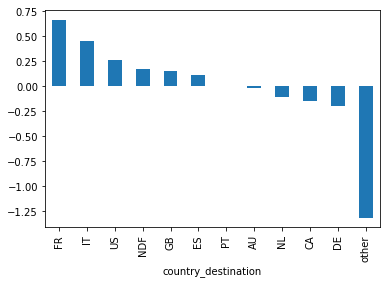

In [42]:
df_train["count"] = 1
df_gender_country = df_train.pivot_table(values = "count", index = ["country_destination"], columns = ["gender"], aggfunc=np.sum)
df_gender_country["FEMALE"] = df_gender_country["FEMALE"] / df_gender_country["FEMALE"].sum() * 100
df_gender_country["MALE"] = df_gender_country["MALE"] / df_gender_country["MALE"].sum() * 100
(df_gender_country["FEMALE"] - df_gender_country["MALE"]).sort_values(ascending = False).plot(kind="bar")

- 여자는 FR, IT 주로 여행을 간다. 
- 남자는 DE, other를 주로 여행을 간다

In [43]:
## code

##### 1-2. Age

In [159]:
labels = np.arange(10).tolist()

In [162]:
df_train["age_cut"] = pd.qcut(df_train[df_train["age"] <= 120]['age'], 10, labels = labels)

In [163]:
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)

In [164]:
df_age_pivot

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
age_cut,,,,,,,,,,,,
0,30,102,116,317,464,231,300,7531,101,26,5229,847
1,35,72,70,131,231,120,137,4724,49,10,4579,624
2,48,103,76,152,321,141,172,5059,52,13,5044,721
3,49,121,84,160,360,155,168,4936,50,22,5206,829
4,50,142,108,245,493,205,292,6783,81,23,6919,1070
5,28,77,51,128,245,131,137,3847,50,12,3642,595
6,64,130,93,171,401,176,203,5795,63,10,4944,792
7,47,113,83,127,409,181,189,6288,48,13,4771,729
8,44,114,73,128,380,185,196,5895,38,11,3851,593


In [167]:
for c in df_age_pivot.index:
    df_age_pivot.iloc[c] = (df_age_pivot.iloc[c] / (df_train["age_cut"] == c).sum() * 100)

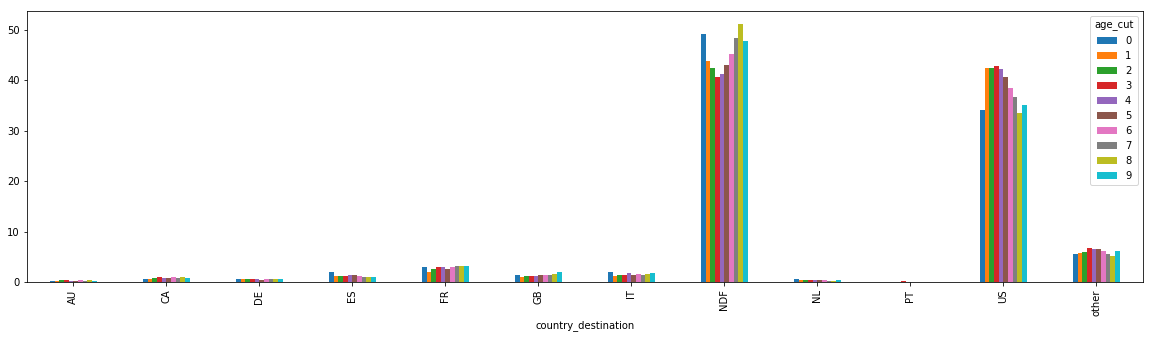

In [168]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))

(0, 5)

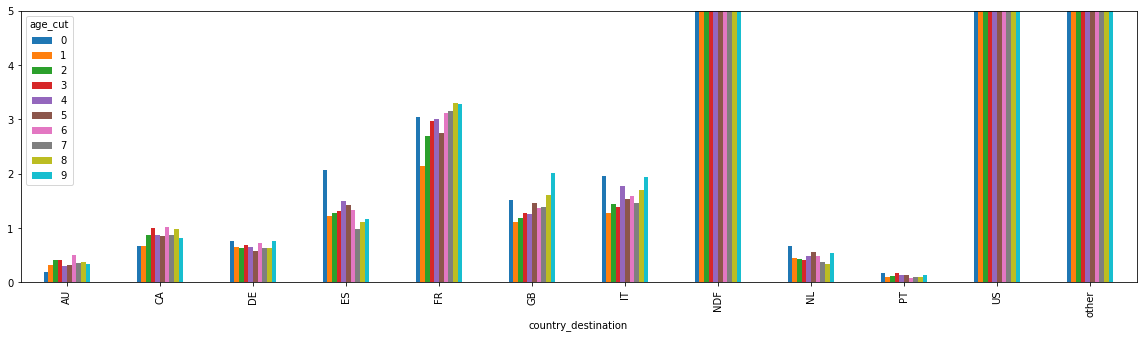

In [169]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))
plt.ylim([0,5])

##### 1-3. first_affiliate_tracked

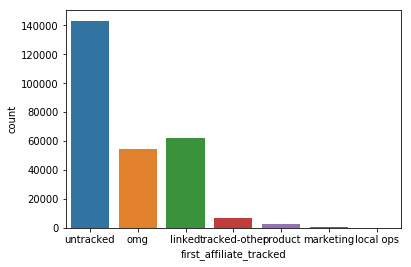

In [27]:
sns.countplot(df_all["first_affiliate_tracked"])

In [30]:
df_all["first_affiliate_tracked"].value_counts() / len(df_all) * 100

untracked        51.962460
linked           22.523925
omg              19.909126
tracked-other     2.415196
product           0.853938
marketing         0.101979
local ops         0.025041
Name: first_affiliate_tracked, dtype: float64

- 전체 특징에서 51.96%가 untracked이기 때문에 최빈값 `untracked` 으로 Missing value 처리

In [31]:
## code
df_train["first_affiliate_tracked"].fillna("untracked")
df_test["first_affiliate_tracked"].fillna("untracked")

##### 1-4. date_first_booking

In [145]:
test_exist = len(df_test) - df_test["date_first_booking"].isnull().sum()
print("Number of date_first_booking in test : {}".format(test_exist))

Number of date_first_booking in test : 0


- test 데이터에는 date_first_booking 특징이 전혀 존재하지 않기 때문에 해당 특지은 사용하지 않는다.

In [35]:
## code
df_train.drop("date_first_booking", axis = 1, inplace = True)
df_test.drop("date_first_booking", axis = 1, inplace = True)

#### (2) Create featrues

##### 2-1. Faithless sign-in

- **가정) 가입을 꼼꼼하게 한 사람일수록 여행을 예약할 확률이 높다** 

  - `age`가 `nan`이거나 `이상값`이거나 `gender`가 `unknown`일 경우, 가입을 대충했다고 가정

In [184]:
s_all_input_train = (df_train['age'] < 120) & (df_train['gender'] != '-unknown-')
s_all_input_test = (df_test['age'] < 120) & (df_test['gender'] != '-unknown-')

In [186]:
df_train['faithless_sign'] = s_all_input_train.apply(lambda x : 0 if x == True else 1)
df_test['faithless_sign'] = s_all_input_test.apply(lambda x : 0 if x == True else 1)

##### 2-2. Session info

- **가정) 사이트를 자주 들어간 사람일수록 여행을 예약할 확률이 높다**
  - 각 `user_id`별 session count 갯수가 많을 수록, 사이트를 자주 들어 왔다고 가정
- **추가 사항 : secs_elapse_mean, secs_elapse_mode, secs_elapse_sum, device_type_mode**

##### action, action_type, action_detail count

In [ ]:
## make action count
tmp = df_session.groupby(["user_id", "action_type"])["secs_elapsed"].count().unstack().fillna(0)
df_session_type = pd.DataFrame(tmp)
df_session_type.rename(columns = lambda x : "type_" + x, inplace = True)

In [ ]:
## make action_type count
tmp = df_session.groupby(["user_id", "action"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action = pd.DataFrame(tmp)
df_session_action.rename(columns = lambda x : "action_" + x, inplace = True)

In [ ]:
## make action_detail count
tmp = df_session.groupby(["user_id", "action_detail"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action_detail = pd.DataFrame(tmp)
df_session_action_detail.rename(columns = lambda x : "detail_" + x, inplace = True)

In [ ]:
df_session_info = df_session_type.merge(df_session_action, how = "left", left_index = True, right_index = True)
df_session_info = df_session_info.merge(df_session_action_detail, how = "left", left_index = True, right_index = True)

In [ ]:
## drop unknown value
df_session_info.drop(["type_-unknown-", "detail_-unknown-"], axis = 1, inplace = True)

In [ ]:
## impute the missing value using median
from sklearn.preprocessing import Imputer

df_train = df_train_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)
df_test = df_test_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_train[df_session_info.columns.tolist()] = imp.fit_transform(df_train[df_session_info.columns.tolist()])
df_test[df_session_info.columns.tolist()] = imp.fit_transform(df_test[df_session_info.columns.tolist()])

##### 2-3. Date info

- **가정1) 주말에 처음 활동한 사람일수록 여행을 예약할 확률이 높다** 
- **가정2) 공휴일에 처음 활동한 사람일수록 여행을 예약할 확률이 높다**
- **추가 사항 : first_active_year, first_active_month, first_active_day, first_active_weekend, create_account_year, create_account_month, create_account_day**

##### 2-4. Lag-time

- **가정) 활동 빈도가 적을 수록 여행을 예약할 확률이 낮다**
  - 처음으로 활동한 날짜 - 처음 계정을 생성한 날짜

In [188]:
df_train["date_account_created"] = pd.to_datetime(df_train["date_account_created"], format = "%Y-%m-%d")
df_train["timestamp_first_active"] = pd.to_datetime(df_train["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')
df_test["date_account_created"] = pd.to_datetime(df_test["date_account_created"], format = "%Y-%m-%d")
df_test["timestamp_first_active"] = pd.to_datetime(df_test["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')

In [189]:
s_train_lag = df_train["timestamp_first_active"] - df_train["date_account_created"]
s_test_lag = df_test["timestamp_first_active"] - df_test["date_account_created"]

In [190]:
df_train["lag_days"] = s_train_lag.apply(lambda x : -1 * x.days)
df_test["lag_days"] = s_test_lag.apply(lambda x : -1 * x.days)
df_train["lag_seconds"] = s_train_lag.apply(lambda x : x.seconds)
df_test["lag_seconds"] = s_test_lag.apply(lambda x : x.seconds)

#### (3) Featrues selection

##### 3-1. Use importance feature

### 4. Modeling

#### (1) Selection Model

#### (2) Parameter tuning

### 5. Analysis the result